## Model Trainning

The dataset is too big, so let's focus on zone 61 and Uber, zone with most orders

In [3]:
import folium
from folium .plugins import HeatMap
import pandas as pd
import os, tempfile
import os
import matplotlib.pyplot as plt
#import geopandas as gpd
#from shapely.geometry import MultiPolygon
import numpy as np
import operator
from sklearn.model_selection import  train_test_split
import xgboost as xgb
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
# import packages for hyperparameters tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

In [5]:
trips = pd.read_csv('uber61data.csv')
trips.head()

,hvfhs_license_num,dispatching_base_num,originating_base_num,request_datetime,on_scene_datetime,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,trip_miles,...,preciptype,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,uvindex
0,HV0003,B02869,B02869,2021-01-01 00:47:19,2021-01-01 00:50:00,2021-01-01 00:51:41,2021-01-01 00:57:38,61,225,1.07,...,NaN,0.0,0.0,NaN,8.0,348,1029.5,10.5,16.0,0
1,HV0003,B02869,B02869,2021-01-01 00:30:16,2021-01-01 00:33:07,2021-01-01 00:33:18,2021-01-01 00:37:15,61,225,0.92,...,NaN,0.0,0.0,NaN,8.0,348,1029.5,10.5,16.0,0
2,HV0003,B02764,B02764,2021-01-01 00:51:26,2021-01-01 00:53:03,2021-01-01 00:55:03,2021-01-01 01:12:41,61,177,2.24,...,NaN,0.0,0.0,NaN,8.0,348,1029.5,10.5,16.0,0
3,HV0003,B02764,B02764,2021-01-01 00:16:45,2021-01-01 00:18:16,2021-01-01 00:19:13,2021-01-01 00:25:59,61,177,1.28,...,NaN,0.0,0.0,NaN,8.0,348,1029.5,10.5,16.0,0
4,HV0003,B02871,B02871,2021-01-01 00:07:44,2021-01-01 00:09:59,2021-01-01 00:11:59,2021-01-01 00:35:21,61,249,6.08,...,NaN,0.0,0.0,NaN,8.0,348,1029.5,10.5,16.0,0


In [6]:
trips.head()

,hvfhs_license_num,dispatching_base_num,originating_base_num,request_datetime,on_scene_datetime,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,trip_miles,...,preciptype,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,uvindex
0,HV0003,B02869,B02869,2021-01-01 00:47:19,2021-01-01 00:50:00,2021-01-01 00:51:41,2021-01-01 00:57:38,61,225,1.07,...,NaN,0.0,0.0,NaN,8.0,348,1029.5,10.5,16.0,0
1,HV0003,B02869,B02869,2021-01-01 00:30:16,2021-01-01 00:33:07,2021-01-01 00:33:18,2021-01-01 00:37:15,61,225,0.92,...,NaN,0.0,0.0,NaN,8.0,348,1029.5,10.5,16.0,0
2,HV0003,B02764,B02764,2021-01-01 00:51:26,2021-01-01 00:53:03,2021-01-01 00:55:03,2021-01-01 01:12:41,61,177,2.24,...,NaN,0.0,0.0,NaN,8.0,348,1029.5,10.5,16.0,0
3,HV0003,B02764,B02764,2021-01-01 00:16:45,2021-01-01 00:18:16,2021-01-01 00:19:13,2021-01-01 00:25:59,61,177,1.28,...,NaN,0.0,0.0,NaN,8.0,348,1029.5,10.5,16.0,0
4,HV0003,B02871,B02871,2021-01-01 00:07:44,2021-01-01 00:09:59,2021-01-01 00:11:59,2021-01-01 00:35:21,61,249,6.08,...,NaN,0.0,0.0,NaN,8.0,348,1029.5,10.5,16.0,0


In [7]:
trips.nunique()

hvfhs_license_num            1
dispatching_base_num        28
originating_base_num        29
request_datetime        147571
on_scene_datetime       147692
pickup_datetime         147642
dropoff_datetime        147567
PULocationID                 1
DOLocationID               256
trip_miles                2650
trip_time                 3864
base_passenger_fare       6245
tolls                       46
bcf                        454
sales_tax                  838
congestion_surcharge         2
tips                       933
driver_pay                5292
shared_request_flag          1
shared_match_flag            1
access_a_ride_flag           1
wav_request_flag             2
wav_match_flag               2
truncate_datetime          744
datetime                   744
name                         1
address                      1
resolvedAddress              1
temp                       161
feelslike                  209
dew                        202
humidity                   680
precip  

In [8]:
#these values are irrelavant or have single value
trips = trips.drop(['hvfhs_license_num','dispatching_base_num', 'originating_base_num','name','address', 'resolvedAddress','PULocationID','shared_request_flag','shared_match_flag','access_a_ride_flag'],axis=1)

In [9]:
trips['request_datetime']=pd.to_datetime(trips['request_datetime'])
trips['request_day']=trips['request_datetime'].dt.day
trips['request_hour']=trips['request_datetime'].dt.hour
trips['request_day_no']=trips['request_datetime'].dt.weekday
trips = trips.drop(['pickup_datetime','dropoff_datetime','datetime','truncate_datetime','request_datetime','on_scene_datetime'],axis=1)

In [10]:
# trips['pickup_datetime']=pd.to_datetime(trips['pickup_datetime'])
# trips['dropoff_datetime']=pd.to_datetime(trips['dropoff_datetime'])
# trips['pickup_day']=trips['pickup_datetime'].dt.day
# trips['dropoff_day']=trips['dropoff_datetime'].dt.day
# trips['pickup_hour']=trips['pickup_datetime'].dt.hour
# trips['dropoff_hour']=trips['dropoff_datetime'].dt.hour
# trips['pickup_day_no']=trips['pickup_datetime'].dt.weekday
# trips['dropoff_day_no']=trips['dropoff_datetime'].dt.weekday

In [11]:
trips.nunique()

DOLocationID             256
trip_miles              2650
trip_time               3864
base_passenger_fare     6245
tolls                     46
bcf                      454
sales_tax                838
congestion_surcharge       2
tips                     933
driver_pay              5292
wav_request_flag           2
wav_match_flag             2
temp                     161
feelslike                209
dew                      202
humidity                 680
precip                    43
precipprob                 2
preciptype                 3
snow                       2
snowdepth                 16
windgust                 150
windspeed                238
winddir                  205
sealevelpressure         248
cloudcover                79
visibility                68
uvindex                    7
request_day               31
request_hour              24
request_day_no             7
dtype: int64

In [12]:
print(trips.isnull().sum())

DOLocationID                 0
trip_miles                   0
trip_time                    0
base_passenger_fare          0
tolls                        0
bcf                          0
sales_tax                    0
congestion_surcharge         0
tips                         0
driver_pay                   0
wav_request_flag             0
wav_match_flag               0
temp                         0
feelslike                    0
dew                          0
humidity                     0
precip                       0
precipprob                   0
preciptype              142317
snow                         0
snowdepth                    0
windgust                 84387
windspeed                    0
winddir                      0
sealevelpressure             0
cloudcover                   0
visibility                   0
uvindex                      0
request_day                  0
request_hour                 0
request_day_no               0
dtype: int64


In [13]:
trips.dtypes

DOLocationID              int64
trip_miles              float64
trip_time                 int64
base_passenger_fare     float64
tolls                   float64
bcf                     float64
sales_tax               float64
congestion_surcharge    float64
tips                    float64
driver_pay              float64
wav_request_flag          int64
wav_match_flag            int64
temp                    float64
feelslike               float64
dew                     float64
humidity                float64
precip                  float64
precipprob                int64
preciptype              float64
snow                    float64
snowdepth               float64
windgust                float64
windspeed               float64
winddir                   int64
sealevelpressure        float64
cloudcover              float64
visibility              float64
uvindex                   int64
request_day               int64
request_hour              int64
request_day_no            int64
dtype: o

In [14]:
trips1 = trips.drop(['windgust','preciptype'],axis=1) #we miss more than half of the data, it is not reasnable to fill with na

In [15]:
#we only care about the final price
trips1['total_price'] = trips1['base_passenger_fare']+ trips1['tolls']+ trips1['bcf']+trips1['sales_tax']+trips1['congestion_surcharge']
trips1 = trips1.drop(['base_passenger_fare','tolls','bcf','sales_tax','congestion_surcharge','tips','driver_pay'],axis=1)
trips1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152837 entries, 0 to 152836
Data columns (total 23 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   DOLocationID      152837 non-null  int64  
 1   trip_miles        152837 non-null  float64
 2   trip_time         152837 non-null  int64  
 3   wav_request_flag  152837 non-null  int64  
 4   wav_match_flag    152837 non-null  int64  
 5   temp              152837 non-null  float64
 6   feelslike         152837 non-null  float64
 7   dew               152837 non-null  float64
 8   humidity          152837 non-null  float64
 9   precip            152837 non-null  float64
 10  precipprob        152837 non-null  int64  
 11  snow              152837 non-null  float64
 12  snowdepth         152837 non-null  float64
 13  windspeed         152837 non-null  float64
 14  winddir           152837 non-null  int64  
 15  sealevelpressure  152837 non-null  float64
 16  cloudcover        15

In [16]:
#change to the object type to avoid the linear relationship with the categorical data
trips1['DOLocationID'] = trips1['DOLocationID'].astype(object) 
trips1['wav_request_flag'] = trips1['wav_request_flag'].astype(object) 
trips1['wav_match_flag'] = trips1['wav_match_flag'].astype(object) 
trips1['request_day'] = trips1['request_day'].astype(object) 
trips1['request_hour'] = trips1['request_hour'].astype(object) 
trips1['request_day_no'] = trips1['request_day_no'].astype(object) 


In [17]:
#get dummified object
categorical_columns = [col for col in trips1.columns.values if trips1[col].dtype == 'object']
df_categorical = trips1[categorical_columns]
df_numeric = trips1.drop(categorical_columns, axis=1)
trips1_dummy = pd.get_dummies(df_categorical)
trips1 = pd.concat([df_numeric, trips1_dummy], axis=1)
trips1.head()

,trip_miles,trip_time,temp,feelslike,dew,humidity,precip,precipprob,snow,snowdepth,...,request_hour_21,request_hour_22,request_hour_23,request_day_no_0,request_day_no_1,request_day_no_2,request_day_no_3,request_day_no_4,request_day_no_5,request_day_no_6
0,1.07,357,2.2,-0.1,-4.9,59.52,0.0,0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0
1,0.92,237,2.2,-0.1,-4.9,59.52,0.0,0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0
2,2.24,1058,2.2,-0.1,-4.9,59.52,0.0,0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0
3,1.28,406,2.2,-0.1,-4.9,59.52,0.0,0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0
4,6.08,1402,2.2,-0.1,-4.9,59.52,0.0,0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0


In [18]:
# #perform one-hot encoding on 'DOLocationID 'column 
# encoder_dol=pd.get_dummies(trips1.DOLocationID,prefix="DOLocationID")
# trips1=trips1.join(encoder_dol)

## LASSO Regression

In [19]:
# Split the data into training and testing
X, y = trips1.drop('total_price', axis = 1), trips1['total_price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

In [20]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 122269 entries, 82889 to 150781
Columns: 338 entries, trip_miles to request_day_no_6
dtypes: float64(12), int64(4), uint8(322)
memory usage: 53.4 MB


In [21]:
def score(y_pred, y_true):
    error = np.square(np.log10(y_pred +1) - np.log10(y_true +1)).mean() ** 0.5
    score = 1 - error
    return score


In [22]:
#Lasso Regression


from sklearn.linear_model import Lasso
#Initializing the Lasso Regressor with Normalization Factor as True
lasso_reg = Lasso(normalize=True)
#Fitting the Training data to the Lasso regressor
lasso_reg.fit(X_train,y_train)
#Predicting for X_test
y_pred_lass =lasso_reg.predict(X_test)

In [23]:
lasso_reg.coef_

array([ 0.,  0., -0., -0.,  0.,  0.,  0., -0., -0., -0., -0.,  0.,  0.,
        0., -0., -0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0., -0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
       -0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -0., -0., -0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -0., -0., -0.,
        0., -0.,  0.,  0.,  0.,  0.,  0., -0., -0.,  0.,  0.,  0.,  0.,
       -0.,  0.,  0., -0.,  0.,  0.,  0.,  0., -0.,  0.,  0.,  0., -0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0., -0.,  0.,  0.,  0.,  0., -0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0

We see that all the coefficients were forced down to zero, including the predictive x feature. The panelty strength lamda is called alpha. The default value is alpha=1.0. We should therefore reduce it because as explained earlier, higher λ values lead to more coefficients forced to 0.

In [24]:
# Let's try alpha = 0.001
from sklearn.linear_model import Lasso
#Initializing the Lasso Regressor with Normalization Factor as True
lasso_reg = Lasso(normalize=True, alpha = 0.001)
#Fitting the Training data to the Lasso regressor
lasso_reg.fit(X_train,y_train)
#Predicting for X_test
y_pred_lass =lasso_reg.predict(X_test)

In [25]:
lasso_reg.coef_

array([ 1.95655963e+00,  7.27960319e-03, -0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        1.32978355e+01, -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        0.00000000e+00, -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -

In [26]:
lasso_reg.score(X_train, y_train)

0.8835504385345434

Compute the R-squared score of the model by using lasso.score. The R-squared score tells us how well the Lasso regression model is able to predict the target variable. A higher R-squared score indicates a better fit between the model and the data. Here, we have a very good result.

In [27]:
# Incorporates cross-validation to select the best value of the regularization parameter alpha.

from sklearn.linear_model import LassoCV
lasso_cv = LassoCV(cv=5).fit(X_train, y_train)
lasso_cv.score(X_train, y_train)

0.808413573547877

In [28]:
lasso_cv.coef_

array([ 6.36127551e-01,  1.53527677e-02, -0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  1.43326271e-03,  0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -3.78410564e-05,
        0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -

In [29]:
alphas = np.logspace(-5, 1 , num=50, base=10)
coefs = []

/shared/centos7/anaconda3/2021.05/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1178610.4085238194, tolerance: 2357.623823708481
  model = cd_fast.enet_coordinate_descent(
/shared/centos7/anaconda3/2021.05/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1169799.3843324522, tolerance: 2357.623823708481
  model = cd_fast.enet_coordinate_descent(
/shared/centos7/anaconda3/2021.05/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1158017.416021623, tolerance: 2357.623823708481
  model = cd_fast.enet_coordinate_descent(
/shared/centos7/anaconda3/2021.05/lib/python3.8/si

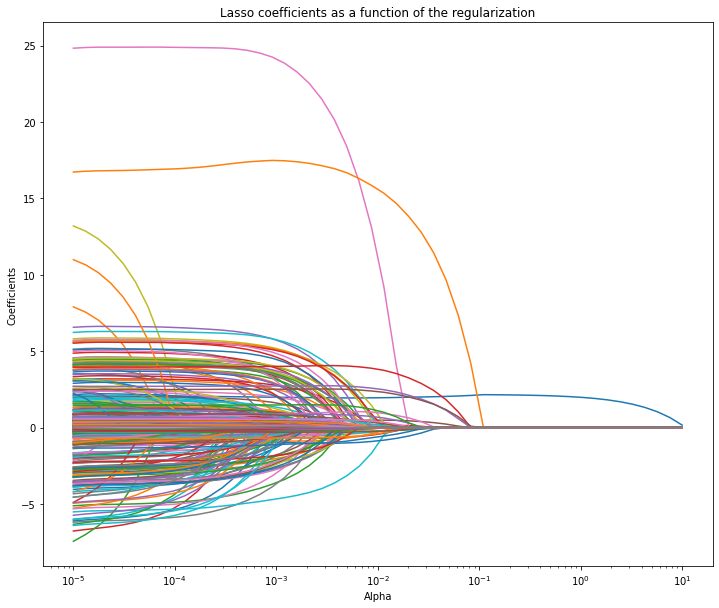

In [30]:
from sklearn.linear_model import Lasso

for a in alphas:
    lasso = Lasso(alpha=a, random_state=88)
    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_)

plt.figure(figsize=(12, 10))
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Coefficients')
plt.title('Lasso coefficients as a function of the regularization')
plt.show()

## Lasso Hyper-parameter Tuning

In [31]:
alpha_grid = {'alpha': np.logspace(-8, -1, num=50, base=10)}

lasso_cv = GridSearchCV(lasso, alpha_grid, scoring='neg_mean_squared_error', cv=10)
lasso_cv.fit(X_train, y_train)

/shared/centos7/anaconda3/2021.05/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1095998.8626393655, tolerance: 2133.9982743668584
  model = cd_fast.enet_coordinate_descent(
/shared/centos7/anaconda3/2021.05/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1058566.5539257561, tolerance: 2089.7264756951845
  model = cd_fast.enet_coordinate_descent(
/shared/centos7/anaconda3/2021.05/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1074649.0623859952, tolerance: 2124.981530994212
  model = cd_fast.enet_coordinate_descent(
/shared/centos7/anaconda3/2021.05/lib/python3.8

GridSearchCV(cv=10, estimator=Lasso(alpha=10.0, random_state=88),
             param_grid={'alpha': array([1.00000000e-08, 1.38949549e-08, 1.93069773e-08, 2.68269580e-08,
       3.72759372e-08, 5.17947468e-08, 7.19685673e-08, 1.00000000e-07,
       1.38949549e-07, 1.93069773e-07, 2.68269580e-07, 3.72759372e-07,
       5.17947468e-07, 7.19685673e-07, 1.00000000e-06, 1.38949549e-06,
       1.93069773e-06, 2.682...
       1.00000000e-04, 1.38949549e-04, 1.93069773e-04, 2.68269580e-04,
       3.72759372e-04, 5.17947468e-04, 7.19685673e-04, 1.00000000e-03,
       1.38949549e-03, 1.93069773e-03, 2.68269580e-03, 3.72759372e-03,
       5.17947468e-03, 7.19685673e-03, 1.00000000e-02, 1.38949549e-02,
       1.93069773e-02, 2.68269580e-02, 3.72759372e-02, 5.17947468e-02,
       7.19685673e-02, 1.00000000e-01])},
             scoring='neg_mean_squared_error')

In [32]:
# One Standard Error Rule: The One Standard Error Rule can be used to compare models with different numbers of
# parameters in order to select the most parsimonious model with low error

def one_standard_error_rule(model, results, param_grid, n_splits, neg_mean_squared_error=True):
    
    assert neg_mean_squared_error == True # function is defined specifically for neg_mean_squared_error
    
    #find model with minimum error, then select the simplest model
    #whose mean falls within 1 standard deviation of the minimum
    
    range_x = param_grid # results['param_'+list(param_grid.keys())[0]].data
    std_vs_x  = pd.Series(results['std_test_score'], index = range_x)
    sem_vs_x  = std_vs_x/np.sqrt(n_splits)
    
    mean_vs_x = pd.Series(results['mean_test_score'], index = range_x)        
    mean_vs_x = mean_vs_x*(-1)
    
    x_min = mean_vs_x.idxmin()
    sem = sem_vs_x[x_min]
    

    if (model=='pcr'):
        x_1se = mean_vs_x[mean_vs_x <= min(mean_vs_x) + sem].index.min()
    elif (model=='ridge') | (model=='lasso'):
        x_1se = mean_vs_x[mean_vs_x <= min(mean_vs_x) + sem].index.max()
        
    #x_1se_idx = int(np.argwhere(range_x == x_1se)[0])
    
    return x_min, x_1se

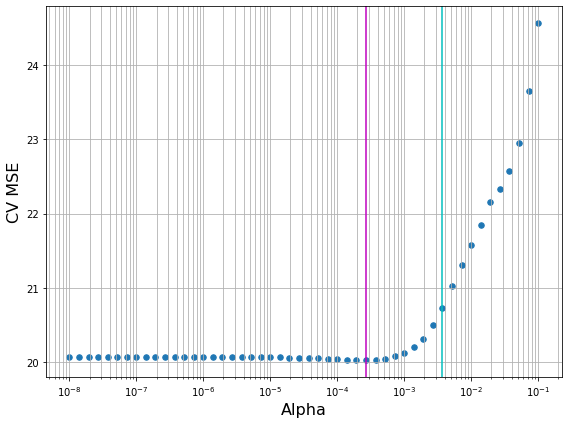

In [33]:
range_alpha = lasso_cv.cv_results_['param_alpha'].data
MSE_scores = lasso_cv.cv_results_['mean_test_score']*(-1)
x_min, x_1se = one_standard_error_rule(model='lasso',
                                       results=lasso_cv.cv_results_,
                                       param_grid=range_alpha,
                                       n_splits=10,
                                       neg_mean_squared_error=True)
plt.figure(figsize=(8, 6))
ax = plt.gca()
ax.set_xscale('log')
plt.xlabel('Alpha', fontsize=16)
plt.ylabel('CV MSE', fontsize=16)
plt.scatter(range_alpha, MSE_scores, s=30)
plt.axvline(x=x_min, color='m')
plt.axvline(x=x_1se, color='c')
plt.grid(True, which='both')

plt.tight_layout()
plt.show()

In [34]:
print('Alpha one standard error rule:', x_1se)

Alpha one standard error rule: 0.003727593720314938


In [35]:
def OSR2(y_train, y_test, y_pred):
    
    SSE = np.sum((y_test - y_pred)**2)
    SST = np.sum((y_test - np.mean(y_train))**2)
                 
    return (1 - SSE/SST)

def MAE(y_test, y_pred):
    
    return (np.mean(abs(y_test - y_pred)))

def RMSE(y_test, y_pred):
    
    return np.sqrt(np.mean((y_test - y_pred)**2))

In [36]:
def print_metrics(model, X_train, y_train, X_test, y_test):

    y_pred_train = pd.Series(model.predict(X_train)).reset_index(drop=True)
    y_pred_test = pd.Series(model.predict(X_test)).reset_index(drop=True)
    y_train = y_train.copy().reset_index(drop=True)
    y_test = y_test.copy().reset_index(drop=True)
        
    print("\nMetrics for fare:\n")
    print('Training R2', OSR2(y_train, y_train, y_pred_train))
    print('Training MAE', MAE(y_train, y_pred_train))
    print('Training RMSE', RMSE(y_train, y_pred_train))

    print('Out-of-sample R2', OSR2(y_train, y_test, y_pred_test))
    print('Out-of-sample MAE', MAE(y_test, y_pred_test))
    print('Out-of-sample RMSE', RMSE(y_test, y_pred_test))
    
    return None

In [37]:
# Use the parameter selected by on standard error rule and redo the lasso

lasso_cv = GridSearchCV(lasso, {'alpha': [x_1se]}, scoring='neg_mean_squared_error', cv=10)
lasso_cv.fit(X_train, y_train)

print_metrics(lasso_cv, X_train, y_train, X_test, y_test)


/shared/centos7/anaconda3/2021.05/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4692.178742863238, tolerance: 2089.7264756951845
  model = cd_fast.enet_coordinate_descent(
/shared/centos7/anaconda3/2021.05/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9323.272679479094, tolerance: 2124.981530994212
  model = cd_fast.enet_coordinate_descent(
/shared/centos7/anaconda3/2021.05/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5264.6647848053835, tolerance: 2130.961478704307
  model = cd_fast.enet_coordinate_descent(
/shared/centos7/anaconda3/2021.05/lib/python3.8/si


Metrics for fare:

Training R2 0.8931589226923415
Training MAE 2.6429325094407523
Training RMSE 4.538874815123461
Out-of-sample R2 0.8929348217197598
Out-of-sample MAE 2.6610348395147843
Out-of-sample RMSE 4.5187829220809785


/shared/centos7/anaconda3/2021.05/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7626.130447737407, tolerance: 2357.623823708481
  model = cd_fast.enet_coordinate_descent(


Variable Selection

In [38]:
cols = X_train.columns
coefs = lasso_cv.best_estimator_.coef_
sorted(zip(abs(coefs), cols))[-28:]

[(1.0235441661749989, 'DOLocationID_76'),
 (1.032562295261063, 'DOLocationID_10'),
 (1.0982539050932363, 'DOLocationID_114'),
 (1.4371760448914734, 'DOLocationID_261'),
 (1.4757188308315075, 'DOLocationID_164'),
 (1.4818626350263338, 'request_hour_5'),
 (1.6721527374124598, 'DOLocationID_79'),
 (1.8166146070600169, 'DOLocationID_125'),
 (1.8387565124821064, 'DOLocationID_186'),
 (1.8672710751249577, 'DOLocationID_107'),
 (1.8764932421558158, 'DOLocationID_144'),
 (1.9502432160251897, 'trip_miles'),
 (2.068962033972015, 'DOLocationID_162'),
 (2.129433570874746, 'DOLocationID_170'),
 (2.2428837632647354, 'DOLocationID_68'),
 (2.382312072171178, 'DOLocationID_249'),
 (2.527158842927438, 'request_hour_8'),
 (2.738390061542031, 'request_hour_7'),
 (3.18321720912659, 'DOLocationID_90'),
 (3.3799192157555504, 'DOLocationID_211'),
 (3.3983853981969854, 'DOLocationID_246'),
 (3.4417311338270715, 'DOLocationID_234'),
 (3.6267872729461588, 'DOLocationID_55'),
 (3.6544670119773683, 'DOLocationID_2

## CART

In [39]:
# Decision Tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree

dtr = DecisionTreeRegressor(min_samples_split=10, 
                            ccp_alpha=0.02,
                            random_state = 10)
dtr = dtr.fit(X_train, y_train)

Node count = 249


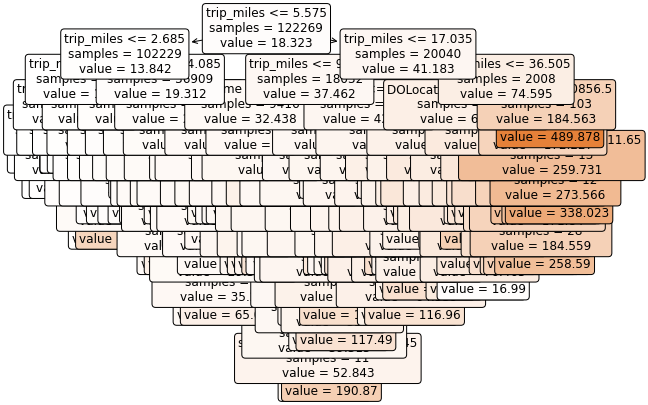

In [40]:
print('Node count =', dtr.tree_.node_count)
plt.figure(figsize=(9,7))
plot_tree(dtr, 
          feature_names=X_train.columns, 
          class_names=['0','1'], 
          filled=True,
          impurity=False,
          rounded=True,
          fontsize=12)
plt.show()

In [41]:
print_metrics(dtr, X_train, y_train, X_test, y_test)


Metrics for fare:

Training R2 0.9027076446042075
Training MAE 2.5885976553810632
Training RMSE 4.331301684645383
Out-of-sample R2 0.8679687951070548
Out-of-sample MAE 2.6927964297991607
Out-of-sample RMSE 5.018057689183923


## GBDT (Gradient Boosting Decision Tree)

In [42]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Initialize the GBDT model
gbdt = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Fit the GBDT model
gbdt.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = gbdt.predict(X_test)

# Evaluate the performance of the GBDT model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('Mean squared error:', mse)
print('Mean absolute error:', mae)
print('R-squared:', r2)

Mean squared error: 19.926063602144517
Mean absolute error: 2.5331283532866475
R-squared: 0.8955214497052342


In [43]:
print_metrics(gbdt, X_train, y_train, X_test, y_test)


Metrics for fare:

Training R2 0.9072941067179136
Training MAE 2.4871660897200143
Training RMSE 4.227978274873134
Out-of-sample R2 0.8955215311741541
Out-of-sample MAE 2.5331283532866427
Out-of-sample RMSE 4.4638619604715055


## XGBoost

Before running a XGBoost model, we must set three types of parameters - general parameters, booster parameters and task parameters.

#### XGBoost hyperparameters tuning

In [81]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor

In [82]:
# Initialize domain space for range of values
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0
    }

In [83]:
# Define objective function
def objective(space):
    clf=xgb.XGBRegressor(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
    
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    clf.fit(X_train, y_train,
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10,verbose=False)
    

    y_pred = clf.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    print ("SCORE:", r2)
    return {'loss': -r2, 'status': STATUS_OK }

In [84]:
#from sklearn.preprocessing import LabelEncoder
#le = LabelEncoder()
#y_train = le.fit_transform(y_train)

In [85]:
# Optimization algorithm
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

job exception: 'XGBRegressor' object has no attribute 'XGBRegressor'



  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]


AttributeError: 'XGBRegressor' object has no attribute 'XGBRegressor'

In [57]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'colsample_bytree': 0.7100258978793019, 'gamma': 3.5477511515834026, 'max_depth': 18.0, 'min_child_weight': 7.0, 'reg_alpha': 180.0, 'reg_lambda': 0.05540213226917953}


In [ ]:
# Using the best hyperparameters to do XGBoost

In [59]:
from xgboost import XGBRegressor

# Initialize the XGBoost model
xgb = XGBRegressor(colsample_bytree= 0.7100258978793019,gamma=3.5477511515834026, max_depth= 18, min_child_weight= 7.0, reg_alpha= 180.0, reg_lambda= 0.05540213226917953)

# Fit the XGBoost model
xgb.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = xgb.predict(X_test)

# Evaluate the performance of the XGBoost model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('Mean squared error:', mse)
print('Mean absolute error:', mae)
print('R-squared:', r2)


Mean squared error: 5702854.267179178
Mean absolute error: 1758.1261072449433
R-squared: -29900.83903222484


In [86]:
#print_metrics(xgb, X_train, y_train, X_test, y_test)

## Comparison Table

In [61]:
comparison_data = {
    
    
    'XGBoost': ['{:.3f}'.format(OSR2(y_train, y_test, xgb.predict(X_test))),
                                        '{:.4f}'.format(RMSE(y_test, xgb.predict(X_test))),
                                        '{:.3f}'.format(MAE(y_test, xgb.predict(X_test)))],
    
    'GBDT': ['{:.3f}'.format(OSR2(y_train, y_test, gbdt.predict(X_test))),
                         '{:.4f}'.format(RMSE(y_test, gbdt.predict(X_test))),
                         '{:.3f}'.format(MAE(y_test, gbdt.predict(X_test)))],
    
    'Lasso Regression': ['{:.3f}'.format(OSR2(y_train, y_test, lasso_cv.predict(X_test))),
                         '{:.4f}'.format(RMSE(y_test, lasso_cv.predict(X_test))),
                         '{:.3f}'.format(MAE(y_test, lasso_cv.predict(X_test)))],
    
    'CART': ['{:.3f}'.format(OSR2(y_train, y_test, dtr.predict(X_test))),
                                 '{:.4f}'.format(RMSE(y_test, dtr.predict(X_test))),
                                 '{:.3f}'.format(MAE(y_test, dtr.predict(X_test)))]
}

comparison_table = pd.DataFrame(data=comparison_data, index=['OSR2', 'Out-of-sample RMSE', 'Out-of-sample MAE'])
comparison_table.style.set_properties(**{'font-size': '12pt',}).set_table_styles([{'selector': 'th', 'props': [('font-size', '10pt')]}])

,XGBoost,GBDT,Lasso Regression,CART
OSR2,-0.837,1.000,1.000,1.000
Out-of-sample RMSE,2388.0650,4.4639,4.5188,5.0181
Out-of-sample MAE,1758.126,2.533,2.661,2.693
